# Tourist satisfaction with transport systems to Mount Etna, Sicily. Part 1. NLP.

# This cell will prompt you to connect this notebook with your google account.
from google.colab import drive                                                                        
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Academy/+ Papers/en_proceso/mount_etna/'


In [1]:
base_dir = '/mnt/g/My Drive/Academy/+ Papers/en_proceso/mount_etna/' # To run locally

# 1. Data pre-processing

In [2]:
#!pip install pycaret[full]

## Importing libraries

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import spacy
#spacy.load("en_core_web_sm")


# NLTK
import string
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet, stopwords
from collections import Counter
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

#ignore log(0) and divide by 0 warning
np.seterr(divide = 'ignore');
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

print('Libraries read!')

Libraries read!


[nltk_data] Downloading package stopwords to /home/juan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/juan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/juan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/juan/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/juan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Reading data

In [4]:
data = pd.read_csv(base_dir + 'data/mount_etna_data.csv')
data = data[['author', 'title', 'content', 'rating']]

# Dropping rows without data in content
data = data.dropna(subset = ['content']).reset_index(drop=True)

print('Data shape: ', data.shape)
data.head()

Data shape:  (3419, 4)


author                                              title  \
0  Michele Amico🇮🇹🇮🇹🇮🇹🇮🇹                                             Etna🇮🇹   
1               Teithiwr                         A hard climb, but worth it   
2      elizabethlascheid  You must see an active volcano at least once i...   
3                 Anne N                    Cost of cable car to the top???   
4  Michele Amico🇮🇹🇮🇹🇮🇹🇮🇹                                     Wonderful Etna   

                                             content  rating  
0  East side of the sicilian island, in the Catan...       5  
1  August 2008. Arrived at Refugio Sapienza just ...       4  
2  Mount Etna is extraordinary. It is an active v...       5  
3  How much does the cable car cost from Rifugio ...       4  
4  It's always a great and sensational emotion to...       5

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3419 entries, 0 to 3418
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author   3417 non-null   object
 1   title    3419 non-null   object
 2   content  3419 non-null   object
 3   rating   3419 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 107.0+ KB


# Filtering comments using EACH keyword, to assess imbalance in dataset

In [6]:
TRANSPORT_KEYWORD = ['bus']


for i in TRANSPORT_KEYWORD:
    # Filtering
    data_filtered = data.copy()
    data_filtered['is_transport_related'] = data_filtered['content'].str.contains(i, case=False, na=False)
    data_filtered = data_filtered[data_filtered['is_transport_related']==True].reset_index(drop=True)
    data_filtered = data_filtered.drop(columns=['is_transport_related'])

    # Creating sentiment_rating feature based on rating
    data_filtered['sentiment_rating'] = np.where(data_filtered['rating'] > 3,1,0)
    #TODO dejar solo 1 y 2 para negativo para tratar de mejorar metricas

    # changing bad and good just for visualization in the recall metric
    data_filtered['sentiment_rating'] = data_filtered['sentiment_rating'].replace([0,1],['negative', 'positive'])
    data_filtered['sentiment_rating'] = data_filtered['sentiment_rating'].replace(['negative','positive'],[1, 0]) # NEGATIVE IS 1!!!!



    # Printing datasets    
    print('Dataset using keyword: {}.'.format(i))
    print('Data shape: ', data_filtered.shape)
    print(data_filtered['sentiment_rating'].value_counts(normalize=True))
    display(data_filtered.head(10))
    print('--------------')

Dataset using keyword: bus.
Data shape:  (932, 5)
0    0.887339
1    0.112661
Name: sentiment_rating, dtype: float64


author                                              title  \
0  elizabethlascheid  You must see an active volcano at least once i...   
1      doorstomanual                       Well orgainised, easy access   
2             John O  Mount Etna - AST bus from Catania, cable car a...   
3             Gunnel                                           Stunning   
4        tugcrumpton  One earring to rule them all but take a coat a...   
5          Jimski777                                 Hiking on Mt. Etna   
6       El_Badgerino        Mount Etna with SAIS Tours - Cheap but good   
7     NickyPAberdeen              Going up Etna is very straightforward   
8       ChoosyChoosa  MOUNT ETNA OR A RIP-OFF CRATER & a great gimmi...   
9             Stinz3                                            A must!   

                                             content  rating  sentiment_rating  
0  Mount Etna is extraordinary. It is an active v...       5                 0  
1  We visited Etna with two small children in Aug...       5                 0  
2  Mount Etna is a stunning day out from Catania....       4                 0  
3  We stayed at Nicolosi 25 k's from Mt Etna. It ...       5                 0  
4  My beloved and I were chatting about various t...       4                 0  
5  This review will start with some practical inf...       4                 0  
6  There are at least 4 different tour companies ...       5                 0  
7  Some reviews on this site imply that ascending...       5                 0  
8  Over 90% of reviewers offer 4- or 5-star ratin...       1                 1  
9  We drove up to the Rifugio Sapienza station, l...       5                 0

--------------


## Filtering comments according to keywords

In [7]:
# TRANSPORT_KEYWORDS = 'transport|rail|cable|car|bus|transportation|mobility|bike'
TRANSPORT_KEYWORDS = 'bus'

In [8]:
# Filtering
data['is_transport_related'] = data['content'].str.contains(TRANSPORT_KEYWORDS, case=False, na=False)
data = data[data['is_transport_related']==True].reset_index(drop=True)
data = data.drop(columns=['is_transport_related'])

# New dataset
print('Data shape: ', data.shape)
data.head(10)

Data shape:  (932, 4)


author                                              title  \
0  elizabethlascheid  You must see an active volcano at least once i...   
1      doorstomanual                       Well orgainised, easy access   
2             John O  Mount Etna - AST bus from Catania, cable car a...   
3             Gunnel                                           Stunning   
4        tugcrumpton  One earring to rule them all but take a coat a...   
5          Jimski777                                 Hiking on Mt. Etna   
6       El_Badgerino        Mount Etna with SAIS Tours - Cheap but good   
7     NickyPAberdeen              Going up Etna is very straightforward   
8       ChoosyChoosa  MOUNT ETNA OR A RIP-OFF CRATER & a great gimmi...   
9             Stinz3                                            A must!   

                                             content  rating  
0  Mount Etna is extraordinary. It is an active v...       5  
1  We visited Etna with two small children in Aug...       5  
2  Mount Etna is a stunning day out from Catania....       4  
3  We stayed at Nicolosi 25 k's from Mt Etna. It ...       5  
4  My beloved and I were chatting about various t...       4  
5  This review will start with some practical inf...       4  
6  There are at least 4 different tour companies ...       5  
7  Some reviews on this site imply that ascending...       5  
8  Over 90% of reviewers offer 4- or 5-star ratin...       1  
9  We drove up to the Rifugio Sapienza station, l...       5

In [9]:
# Creating sentiment_rating feature based on rating
data['sentiment_rating'] = np.where(data['rating'] > 3,1,0)
#TODO dejar solo 1 y 2 para negativo para tratar de mejorar metricas

# changing bad and good just for visualization in the recall metric
data['sentiment_rating'] = data['sentiment_rating'].replace([0,1],['negative', 'positive'])
data['sentiment_rating'] = data['sentiment_rating'].replace(['negative','positive'],[1, 0]) # NEGATIVE IS 1!!!!

In [10]:
data['sentiment_rating'].value_counts(normalize=True)

0    0.887339
1    0.112661
Name: sentiment_rating, dtype: float64

#### This data is imbalanced, as 90% of the reviews are positive (4, 5) and just 10% are negative (1, 2, 3)

23486


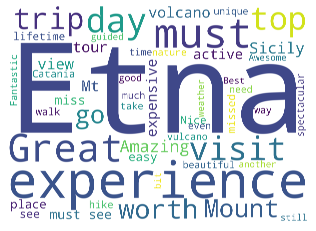

In [11]:
# Wordcloud of title

word_cloud_text = ''.join(data['title'])
print(len(word_cloud_text))
wordcloud = WordCloud(max_font_size=500, 
                      max_words=50,
                      background_color="white",
                      scale=10,
                      width=1000, 
                      height=720).generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(0,0.3)
plt.savefig(base_dir + 'output/bus/title_wordcloud.png', dpi=400,  bbox_inches='tight')
plt.show();

790096


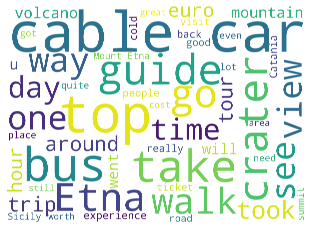

In [12]:
# Wordcloud of content

word_cloud_text = ''.join(data['content'])
print(len(word_cloud_text))
wordcloud = WordCloud(max_font_size=500, 
                      max_words=50,
                      background_color="white",
                      scale=10,
                      width=1000, 
                      height=720).generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(0,0.3)
plt.savefig(base_dir + 'output/bus/content_wordcloud.png', dpi=400,  bbox_inches='tight')
plt.show();

# 3. NLP for title

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   author            932 non-null    object
 1   title             932 non-null    object
 2   content           932 non-null    object
 3   rating            932 non-null    int64 
 4   sentiment_rating  932 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 36.5+ KB


In [14]:
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')

In [15]:
noise_words_title = []
token_lists_title = [word_tokenize(each) for each in data['title']]
tokens_title = [item for sublist in token_lists_title for item in sublist]
print("Number of unique tokens then: ",len(set(tokens_title)))


Number of unique tokens then:  1129


In [16]:
one_percentile_title = int(len(set(tokens_title)) * 0.01)
top_1_percentile_title = Counter(tokens_title).most_common(one_percentile_title)
bottom_1_percentile_title = Counter(tokens_title).most_common()[-one_percentile_title:]

print(top_1_percentile_title[:10])
print('---------------')
print(bottom_1_percentile_title[:10])

[('!', 228), ('the', 135), ('to', 127), ('Etna', 119), ('experience', 97), ('a', 95), (',', 85), ('A', 79), ('.', 72), ('and', 70)]
---------------
[('Glad', 1), ('Recommended', 1), ('major', 1), ('Road', 1), ('Biked', 1), ('piece', 1), ('Over-rated', 1), ('Up', 1), ('Marvellous', 1), ('Took', 1)]


In [17]:
noise_words_title.extend(eng_stop_words)
noise_words_title.extend([word for word, val in top_1_percentile_title])
noise_words_title.extend([word for word, val in bottom_1_percentile_title])

In [18]:
data

author                                              title  \
0    elizabethlascheid  You must see an active volcano at least once i...   
1        doorstomanual                       Well orgainised, easy access   
2               John O  Mount Etna - AST bus from Catania, cable car a...   
3               Gunnel                                           Stunning   
4          tugcrumpton  One earring to rule them all but take a coat a...   
..                 ...                                                ...   
927           Johan_DK                        Took the long Etna Sud Trek   
928            Keith P                                   A dusty old hill   
929           DidgeAFC                                       Trip to Etna   
930            Yaron S                                  Unique experience   
931            jpg1747                                      Fabulous Tour   

                                               content  rating  \
0    Mount Etna is extraordinary. It is an active v...       5   
1    We visited Etna with two small children in Aug...       5   
2    Mount Etna is a stunning day out from Catania....       4   
3    We stayed at Nicolosi 25 k's from Mt Etna. It ...       5   
4    My beloved and I were chatting about various t...       4   
..                                                 ...     ...   
927  Just back from a long day at Etna Sud...,We ar...       4   
928  Very expensive cable car ride - plus bus to su...       3   
929  We drove to the base station where you take th...       4   
930  Very unique experience. It's not every day you...       5   
931  We were a group of 7 - we had a great time vis...       5   

     sentiment_rating  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
927                 0  
928                 1  
929                 0  
930                 0  
931                 0  

[932 rows x 5 columns]

In [19]:
# Pycaret
from pycaret.nlp import *

exp_name = setup(data = data[['title', 'sentiment_rating']],  
                 target = 'title',
                 session_id = 42,
                 custom_stopwords = noise_words_title
                )

In [20]:
lda_title = create_model('lda', multi_core = True) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_title)
lda_title_data = assign_model(lda_title)

In [21]:
print('Shape of lda_title_data: ', lda_title_data.shape)
display(lda_title_data.head())
print('------')
lda_title_data.describe(include='all')

Shape of lda_title_data:  (932, 8)


title  sentiment_rating   Topic_0   Topic_1  \
0  must see active volcano least life                 0  0.035770  0.372612   
1               orgainise easy access                 0  0.062622  0.812080   
2                           cable car                 0  0.083341  0.083341   
3                                                     0  0.250000  0.250000   
4                earre rule take coat                 0  0.050103  0.461134   

    Topic_2   Topic_3 Dominant_Topic  Perc_Dominant_Topic  
0  0.035760  0.555858        Topic 3                 0.56  
1  0.062630  0.062667        Topic 1                 0.81  
2  0.083342  0.749975        Topic 3                 0.75  
3  0.250000  0.250000        Topic 0                 0.25  
4  0.050949  0.437814        Topic 1                 0.46

------


title  sentiment_rating     Topic_0     Topic_1     Topic_2  \
count    932        932.000000  932.000000  932.000000  932.000000   
unique   563               NaN         NaN         NaN         NaN   
top                        NaN         NaN         NaN         NaN   
freq     144               NaN         NaN         NaN         NaN   
mean     NaN          0.112661    0.279717    0.274279    0.237726   
std      NaN          0.316348    0.240155    0.242050    0.223730   
min      NaN          0.000000    0.020838    0.027799    0.020947   
25%      NaN          0.000000    0.083470    0.083425    0.083361   
50%      NaN          0.000000    0.154511    0.125242    0.125025   
75%      NaN          0.000000    0.421733    0.416240    0.250000   
max      NaN          1.000000    0.914293    0.937374    0.892074   

           Topic_3 Dominant_Topic  Perc_Dominant_Topic  
count   932.000000            932           932.000000  
unique         NaN              4                  NaN  
top            NaN        Topic 0                  NaN  
freq           NaN            392                  NaN  
mean      0.208278            NaN             0.587725  
std       0.199844            NaN             0.183070  
min       0.020841            NaN             0.250000  
25%       0.083365            NaN             0.470000  
50%       0.125024            NaN             0.620000  
75%       0.250000            NaN             0.750000  
max       0.878545            NaN             0.940000

## Tuning number of topics

In [22]:
tuned_lda_title = tune_model(model = 'lda', 
                             multi_core = True, 
                             supervised_target = 'sentiment_rating',
                             custom_grid = [2,3,4],
                             optimize = 'AUC'
                             )

IntProgress(value=0, description='Processing: ', max=13)

Output()

Best Model: Latent Dirichlet Allocation | # Topics: 3 | AUC : 0.699


In [23]:
lda_title_tuned = create_model('lda', multi_core = True, num_topics=tuned_lda_title.num_topics) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_title_tuned)
lda_title_data_tuned = assign_model(lda_title_tuned)
lda_title_data_tuned = lda_title_data_tuned.add_prefix('Title_')
lda_title_data_tuned['Title_Dominant_Topic'] = lda_title_data_tuned['Title_Dominant_Topic'].replace(' ', '_', regex=True)

In [24]:
print('Shape of lda_title_data_tuned: ', lda_title_data_tuned.shape)
display(lda_title_data_tuned.head())
print('------')
lda_title_data_tuned.describe(include='all')

Shape of lda_title_data_tuned:  (932, 7)


Title_title  Title_sentiment_rating  Title_Topic_0  \
0  must see active volcano least life                       0       0.368117   
1               orgainise easy access                       0       0.084181   
2                           cable car                       0       0.111263   
3                                                           0       0.333333   
4                earre rule take coat                       0       0.387219   

   Title_Topic_1  Title_Topic_2 Title_Dominant_Topic  \
0       0.583962       0.047921              Topic_1   
1       0.831498       0.084322              Topic_1   
2       0.772676       0.116061              Topic_1   
3       0.333333       0.333333              Topic_0   
4       0.363460       0.249321              Topic_0   

   Title_Perc_Dominant_Topic  
0                       0.58  
1                       0.83  
2                       0.77  
3                       0.33  
4                       0.39

------


Title_title  Title_sentiment_rating  Title_Topic_0  Title_Topic_1  \
count          932              932.000000     932.000000     932.000000   
unique         563                     NaN            NaN            NaN   
top                                    NaN            NaN            NaN   
freq           144                     NaN            NaN            NaN   
mean           NaN                0.112661       0.345572       0.357177   
std            NaN                0.316348       0.247293       0.255838   
min            NaN                0.000000       0.027826       0.029615   
25%            NaN                0.000000       0.114576       0.166698   
50%            NaN                0.000000       0.333333       0.333333   
75%            NaN                0.000000       0.594147       0.649243   
max            NaN                1.000000       0.924200       0.930461   

        Title_Topic_2 Title_Dominant_Topic  Title_Perc_Dominant_Topic  
count      932.000000                  932                 932.000000  
unique            NaN                    3                        NaN  
top               NaN              Topic_0                        NaN  
freq              NaN                  432                        NaN  
mean         0.297251                  NaN                   0.634345  
std          0.237053                  NaN                   0.168544  
min          0.034468                  NaN                   0.330000  
25%          0.111464                  NaN                   0.520000  
50%          0.167128                  NaN                   0.670000  
75%          0.333444                  NaN                   0.780000  
max          0.942559                  NaN                   0.940000

In [25]:
lda_title_data_tuned

Title_title  Title_sentiment_rating  \
0    must see active volcano least life                       0   
1                 orgainise easy access                       0   
2                             cable car                       0   
3                                                             0   
4                  earre rule take coat                       0   
..                                  ...                     ...   
927                           take long                       0   
928                                                           1   
929                                                           0   
930                              unique                       0   
931                       fabulous tour                       0   

     Title_Topic_0  Title_Topic_1  Title_Topic_2 Title_Dominant_Topic  \
0         0.368117       0.583962       0.047921              Topic_1   
1         0.084181       0.831498       0.084322              Topic_1   
2         0.111263       0.772676       0.116061              Topic_1   
3         0.333333       0.333333       0.333333              Topic_0   
4         0.387219       0.363460       0.249321              Topic_0   
..             ...            ...            ...                  ...   
927       0.111172       0.112704       0.776124              Topic_2   
928       0.333333       0.333333       0.333333              Topic_0   
929       0.333333       0.333333       0.333333              Topic_0   
930       0.666446       0.166762       0.166792              Topic_0   
931       0.111197       0.775184       0.113619              Topic_1   

     Title_Perc_Dominant_Topic  
0                         0.58  
1                         0.83  
2                         0.77  
3                         0.33  
4                         0.39  
..                         ...  
927                       0.78  
928                       0.33  
929                       0.33  
930                       0.67  
931                       0.78  

[932 rows x 7 columns]

## Wordclouds, bigrams and trigrams for Titles

Wordcloud for Title_Topic_0
0    382
1     50
Name: Title_sentiment_rating, dtype: int64


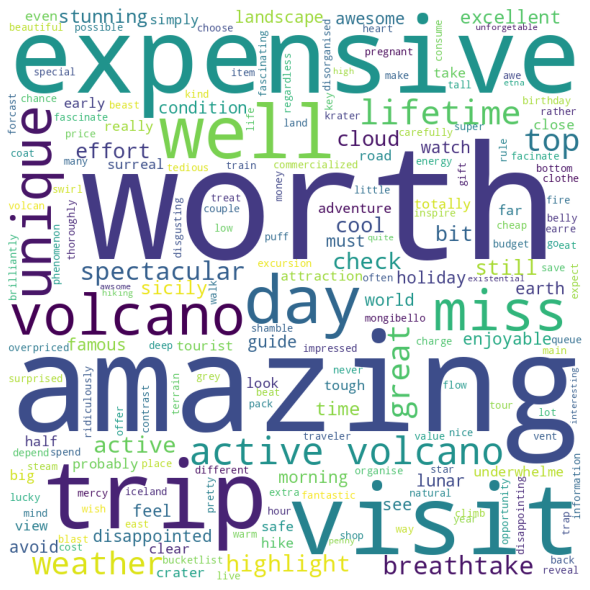

----------------------------------


Wordcloud for Title_Topic_1
0    272
1     24
Name: Title_sentiment_rating, dtype: int64


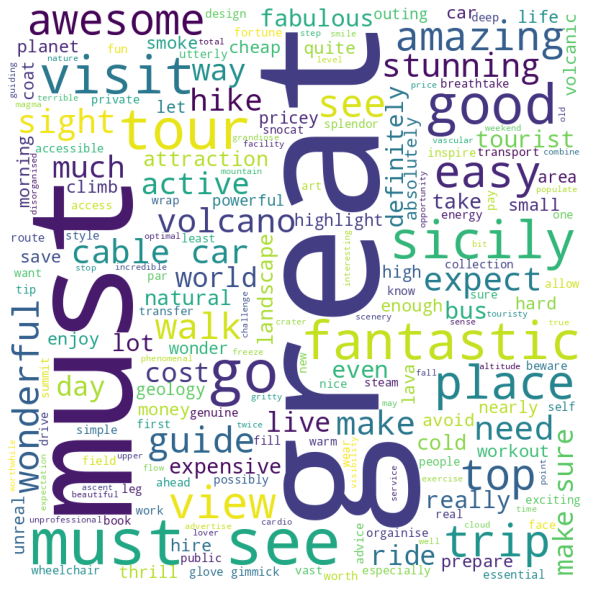

----------------------------------


Wordcloud for Title_Topic_2
0    173
1     31
Name: Title_sentiment_rating, dtype: int64


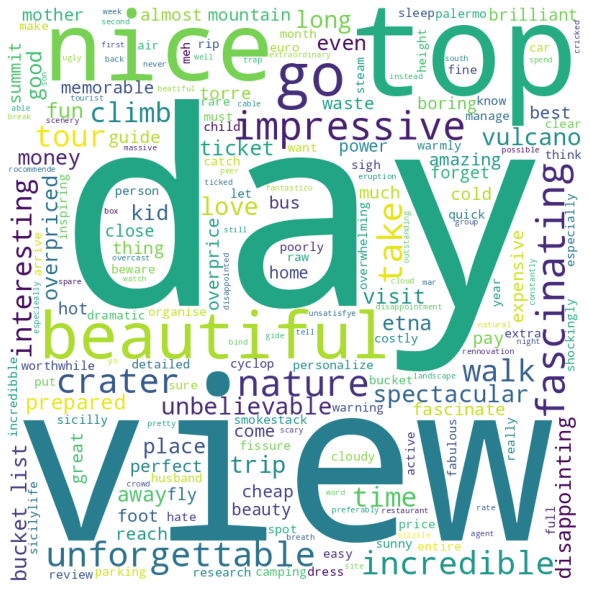

----------------------------------




In [26]:
for i in lda_title_data_tuned.filter(regex='Title_Topic_'):
    print('Wordcloud for {}'.format(i))
    title_topic = lda_title_data_tuned[lda_title_data_tuned['Title_Dominant_Topic']== i[len('Title_'):]]
    print(title_topic['Title_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_title_tuned, plot='wordcloud', topic_num=i[len('Title_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_title_tuned, plot='bigram', topic_num=i[len('Title_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_title_tuned, plot='trigram', topic_num=i[len('Title_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Titles - SENTIMENT POSITIVE

Wordcloud for Title_Topic_0
0    382
Name: Title_sentiment_rating, dtype: int64


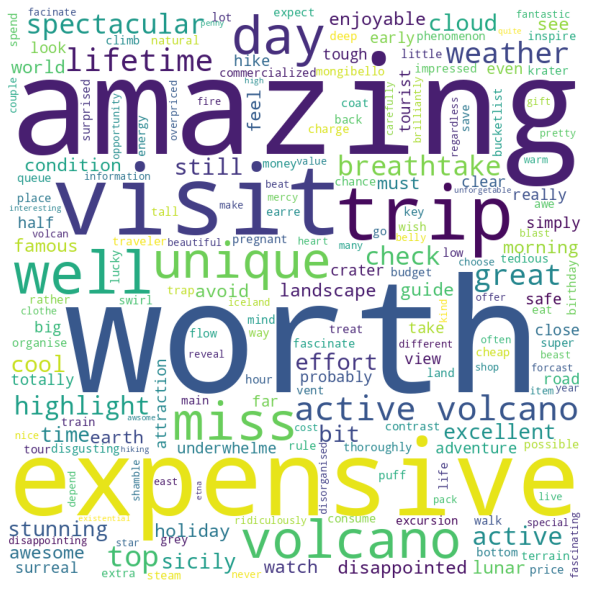

----------------------------------


Wordcloud for Title_Topic_1
0    272
Name: Title_sentiment_rating, dtype: int64


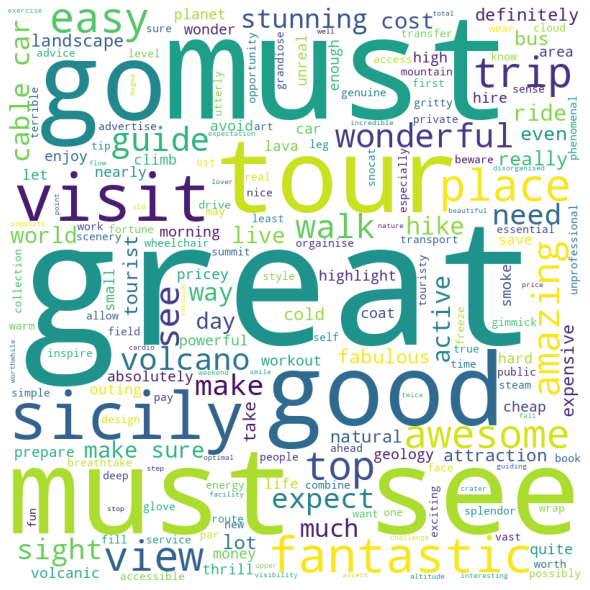

----------------------------------


Wordcloud for Title_Topic_2
0    173
Name: Title_sentiment_rating, dtype: int64


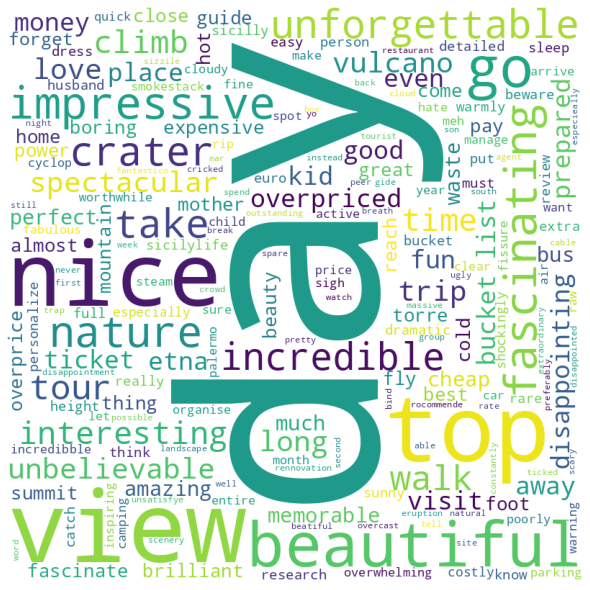

----------------------------------




In [27]:
for i in lda_title_data_tuned.filter(regex='Title_Topic_'):
    print('Wordcloud for {}'.format(i))
    title_topic = lda_title_data_tuned[lda_title_data_tuned['Title_sentiment_rating']== 0]
    title_topic = title_topic[title_topic['Title_Dominant_Topic']== i[len('Title_'):]]
    print(title_topic['Title_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_title_tuned, plot='wordcloud', topic_num=i[len('Title_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_title_tuned, plot='bigram', topic_num=i[len('Title_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_title_tuned, plot='trigram', topic_num=i[len('Title_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Titles - SENTIMENT NEGATIVE

Wordcloud for Title_Topic_0
1    50
Name: Title_sentiment_rating, dtype: int64


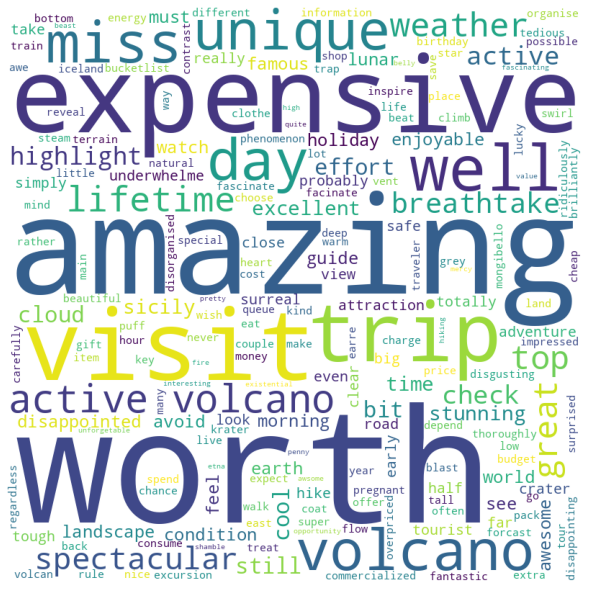

----------------------------------


Wordcloud for Title_Topic_1
1    24
Name: Title_sentiment_rating, dtype: int64


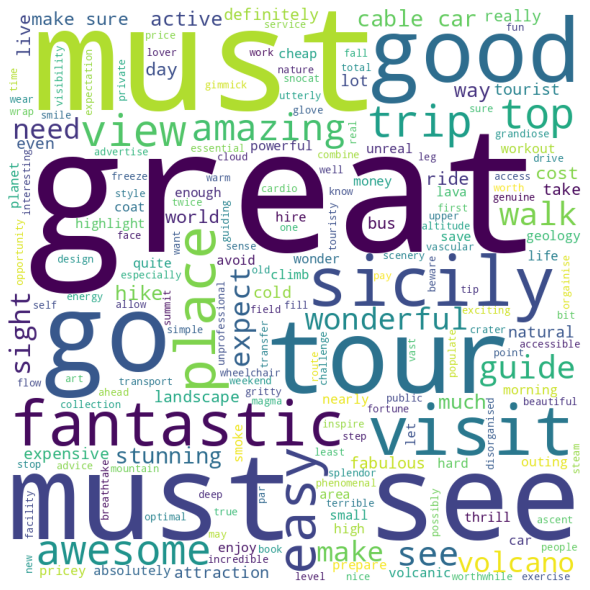

----------------------------------


Wordcloud for Title_Topic_2
1    31
Name: Title_sentiment_rating, dtype: int64


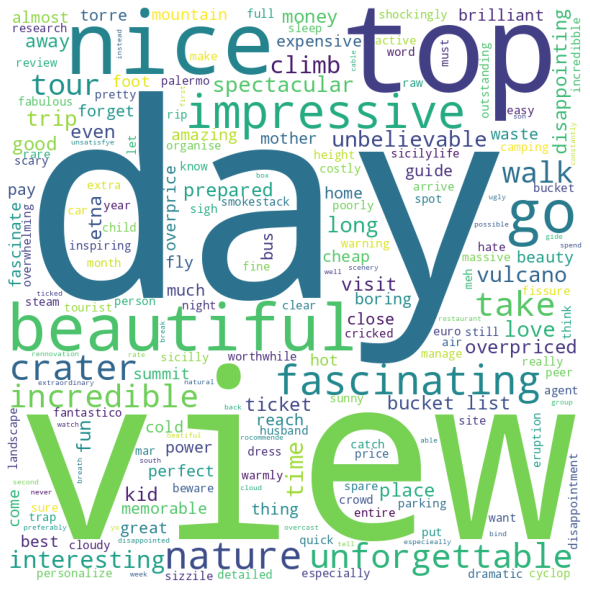

----------------------------------




In [28]:
for i in lda_title_data_tuned.filter(regex='Title_Topic_'):
    print('Wordcloud for {}'.format(i))
    title_topic = lda_title_data_tuned[lda_title_data_tuned['Title_sentiment_rating']== 1]
    title_topic = title_topic[title_topic['Title_Dominant_Topic']== i[len('Title_'):]]
    print(title_topic['Title_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_title_tuned, plot='wordcloud', topic_num=i[len('Title_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_title_tuned, plot='bigram', topic_num=i[len('Title_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_title_tuned, plot='trigram', topic_num=i[len('Title_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Evaluation of the model

In [29]:
# Evaluation of the model
evaluate_model(lda_title_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

In [30]:
lda_title_data_tuned

Title_title  Title_sentiment_rating  \
0    must see active volcano least life                       0   
1                 orgainise easy access                       0   
2                             cable car                       0   
3                                                             0   
4                  earre rule take coat                       0   
..                                  ...                     ...   
927                           take long                       0   
928                                                           1   
929                                                           0   
930                              unique                       0   
931                       fabulous tour                       0   

     Title_Topic_0  Title_Topic_1  Title_Topic_2 Title_Dominant_Topic  \
0         0.368117       0.583962       0.047921              Topic_1   
1         0.084181       0.831498       0.084322              Topic_1   
2         0.111263       0.772676       0.116061              Topic_1   
3         0.333333       0.333333       0.333333              Topic_0   
4         0.387219       0.363460       0.249321              Topic_0   
..             ...            ...            ...                  ...   
927       0.111172       0.112704       0.776124              Topic_2   
928       0.333333       0.333333       0.333333              Topic_0   
929       0.333333       0.333333       0.333333              Topic_0   
930       0.666446       0.166762       0.166792              Topic_0   
931       0.111197       0.775184       0.113619              Topic_1   

     Title_Perc_Dominant_Topic  
0                         0.58  
1                         0.83  
2                         0.77  
3                         0.33  
4                         0.39  
..                         ...  
927                       0.78  
928                       0.33  
929                       0.33  
930                       0.67  
931                       0.78  

[932 rows x 7 columns]

In [31]:
lda_title_data_tuned.to_csv(base_dir + 'data/bus/lda_title_data_tuned.csv', index=False)

In [32]:
save_model(lda_title_tuned, base_dir + 'models/bus/model_title_jupyter')

Model Succesfully Saved


(<gensim.models.ldamulticore.LdaMulticore at 0x7fe01183e670>,
 '/mnt/g/My Drive/Academy/+ Papers/en_proceso/mount_etna/models/bus/model_title_jupyter.pkl')

# 4. NLP for review

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   author            932 non-null    object
 1   title             932 non-null    object
 2   content           932 non-null    object
 3   rating            932 non-null    int64 
 4   sentiment_rating  932 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 36.5+ KB


In [34]:
noise_words_review = []
token_lists_review = [word_tokenize(each) for each in data['content']]
tokens_review = [item for sublist in token_lists_review for item in sublist]
print("Number of unique tokens then: ",len(set(tokens_review)))


Number of unique tokens then:  9753


In [35]:
one_percentile_review = int(len(set(tokens_review)) * 0.01)
top_1_percentile_review = Counter(tokens_review).most_common(one_percentile_review)
bottom_1_percentile_review = Counter(tokens_review).most_common()[-one_percentile_review:]

print(top_1_percentile_review[:10])
print('---------------')
print(bottom_1_percentile_review[:10])

[('the', 9446), ('.', 6811), (',', 5729), ('to', 5194), ('and', 4839), ('a', 4009), ('you', 2608), ('of', 2599), ('is', 1984), ('was', 1968)]
---------------
[('Saopienza', 1), ('truck/bus', 1), ('Obvious', 1), ('reflections', 1), (',Not', 1), ('worth.', 1), ('enjoysicily.eu', 1), ('Spoke', 1), ('garlic', 1), ('complimentary', 1)]


In [36]:
noise_words_review.extend(eng_stop_words)
noise_words_review.extend([word for word, val in top_1_percentile_review])
noise_words_review.extend([word for word, val in bottom_1_percentile_review])

In [37]:
data

author                                              title  \
0    elizabethlascheid  You must see an active volcano at least once i...   
1        doorstomanual                       Well orgainised, easy access   
2               John O  Mount Etna - AST bus from Catania, cable car a...   
3               Gunnel                                           Stunning   
4          tugcrumpton  One earring to rule them all but take a coat a...   
..                 ...                                                ...   
927           Johan_DK                        Took the long Etna Sud Trek   
928            Keith P                                   A dusty old hill   
929           DidgeAFC                                       Trip to Etna   
930            Yaron S                                  Unique experience   
931            jpg1747                                      Fabulous Tour   

                                               content  rating  \
0    Mount Etna is extraordinary. It is an active v...       5   
1    We visited Etna with two small children in Aug...       5   
2    Mount Etna is a stunning day out from Catania....       4   
3    We stayed at Nicolosi 25 k's from Mt Etna. It ...       5   
4    My beloved and I were chatting about various t...       4   
..                                                 ...     ...   
927  Just back from a long day at Etna Sud...,We ar...       4   
928  Very expensive cable car ride - plus bus to su...       3   
929  We drove to the base station where you take th...       4   
930  Very unique experience. It's not every day you...       5   
931  We were a group of 7 - we had a great time vis...       5   

     sentiment_rating  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
927                 0  
928                 1  
929                 0  
930                 0  
931                 0  

[932 rows x 5 columns]

In [38]:
# Pycaret
from pycaret.nlp import *

exp_name = setup(data = data[['content', 'sentiment_rating']],  
                 target = 'content',
                 session_id = 42,
                 custom_stopwords = noise_words_review
                )

In [39]:
lda_review = create_model('lda', multi_core = True) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_review)
lda_review_data = assign_model(lda_review)

In [40]:
print('Shape of lda_review_data: ', lda_review_data.shape)
display(lda_review_data.head())
print('------')
lda_review_data.describe(include='all')

Shape of lda_review_data:  (932, 8)


content  sentiment_rating  \
0  extraordinary active beautiful landscape ever ...                 0   
1  small child august use company sight however g...                 0   
2  follow unheard deduction price ast convenient ...                 0   
3  stay half hour parking place choose early_morn...                 0   
4  beloved chat various thing evening mention ups...                 0   

    Topic_0   Topic_1   Topic_2   Topic_3 Dominant_Topic  Perc_Dominant_Topic  
0  0.006137  0.754458  0.006286  0.233119        Topic 1                 0.75  
1  0.460662  0.528870  0.005243  0.005225        Topic 1                 0.53  
2  0.500471  0.444750  0.001990  0.052790        Topic 0                 0.50  
3  0.003503  0.989560  0.003544  0.003392        Topic 1                 0.99  
4  0.000657  0.998041  0.000658  0.000644        Topic 1                 1.00

------


content  sentiment_rating  \
count                                                 932        932.000000   
unique                                                932               NaN   
top     extraordinary active beautiful landscape ever ...               NaN   
freq                                                    1               NaN   
mean                                                  NaN          0.112661   
std                                                   NaN          0.316348   
min                                                   NaN          0.000000   
25%                                                   NaN          0.000000   
50%                                                   NaN          0.000000   
75%                                                   NaN          0.000000   
max                                                   NaN          1.000000   

           Topic_0     Topic_1     Topic_2     Topic_3 Dominant_Topic  \
count   932.000000  932.000000  932.000000  932.000000            932   
unique         NaN         NaN         NaN         NaN              4   
top            NaN         NaN         NaN         NaN        Topic 1   
freq           NaN         NaN         NaN         NaN            520   
mean      0.159777    0.518450    0.241076    0.080697            NaN   
std       0.290466    0.386140    0.336520    0.193257            NaN   
min       0.000449    0.002136    0.000452    0.000644            NaN   
25%       0.005367    0.033177    0.007289    0.005013            NaN   
50%       0.010786    0.567012    0.020092    0.009563            NaN   
75%       0.148668    0.940199    0.425480    0.021768            NaN   
max       0.993684    0.998041    0.993619    0.987494            NaN   

        Perc_Dominant_Topic  
count            932.000000  
unique                  NaN  
top                     NaN  
freq                    NaN  
mean               0.812994  
std                0.174775  
min                0.370000  
25%                0.650000  
50%                0.890000  
75%                0.970000  
max                1.000000

## Tuning number of topics

In [41]:
tuned_lda_review = tune_model(model = 'lda', 
                             multi_core = True, 
                             supervised_target = 'sentiment_rating',
                             custom_grid = [2,3,4],
                             optimize = 'AUC'
                             )

IntProgress(value=0, description='Processing: ', max=13)

Output()

Best Model: Latent Dirichlet Allocation | # Topics: 3 | AUC : 0.697


In [42]:
lda_review_tuned = create_model('lda', multi_core = True, num_topics=tuned_lda_review.num_topics) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_review_tuned)
lda_review_data_tuned = assign_model(lda_review_tuned)
lda_review_data_tuned = lda_review_data_tuned.add_prefix('Review_')
lda_review_data_tuned['Review_Dominant_Topic'] = lda_review_data_tuned['Review_Dominant_Topic'].replace(' ', '_', regex=True)

In [43]:
print('Shape of lda_review_data_tuned: ', lda_review_data_tuned.shape)
display(lda_review_data_tuned.head())
print('------')
lda_review_data_tuned.describe(include='all')

Shape of lda_review_data_tuned:  (932, 7)


Review_content  Review_sentiment_rating  \
0  extraordinary active beautiful landscape ever ...                        0   
1  small child august use company sight however g...                        0   
2  follow unheard deduction price ast convenient ...                        0   
3  stay half hour parking place choose early_morn...                        0   
4  beloved chat various thing evening mention ups...                        0   

   Review_Topic_0  Review_Topic_1  Review_Topic_2 Review_Dominant_Topic  \
0        0.009175        0.859691        0.131135               Topic_1   
1        0.494376        0.497661        0.007963               Topic_1   
2        0.508946        0.460836        0.030218               Topic_0   
3        0.005486        0.660059        0.334455               Topic_1   
4        0.000953        0.998054        0.000993               Topic_1   

   Review_Perc_Dominant_Topic  
0                        0.86  
1                        0.50  
2                        0.51  
3                        0.66  
4                        1.00

------


Review_content  \
count                                                 932   
unique                                                932   
top     extraordinary active beautiful landscape ever ...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

        Review_sentiment_rating  Review_Topic_0  Review_Topic_1  \
count                932.000000      932.000000      932.000000   
unique                      NaN             NaN             NaN   
top                         NaN             NaN             NaN   
freq                        NaN             NaN             NaN   
mean                   0.112661        0.185283        0.495651   
std                    0.316348        0.297021        0.383060   
min                    0.000000        0.000953        0.002288   
25%                    0.000000        0.009078        0.042977   
50%                    0.000000        0.021154        0.496723   
75%                    0.000000        0.250124        0.924150   
max                    1.000000        0.989879        0.998054   

        Review_Topic_2 Review_Dominant_Topic  Review_Perc_Dominant_Topic  
count       932.000000                   932                  932.000000  
unique             NaN                     3                         NaN  
top                NaN               Topic_1                         NaN  
freq               NaN                   478                         NaN  
mean          0.319066                   NaN                    0.810322  
std           0.355184                   NaN                    0.177477  
min           0.000993                   NaN                    0.350000  
25%           0.014519                   NaN                    0.660000  
50%           0.133287                   NaN                    0.890000  
75%           0.611078                   NaN                    0.970000  
max           0.995282                   NaN                    1.000000

In [44]:
lda_review_data_tuned

Review_content  \
0    extraordinary active beautiful landscape ever ...   
1    small child august use company sight however g...   
2    follow unheard deduction price ast convenient ...   
3    stay half hour parking place choose early_morn...   
4    beloved chat various thing evening mention ups...   
..                                                 ...   
927  back arrive southern yesterday etna high possi...   
928  expensive ride summit try avoid crowd tourist ...   
929  drive station nice visited relief give heat ba...   
930  unique chance climb active ride quite expensiv...   
931  group great visit place big luca entertain wel...   

     Review_sentiment_rating  Review_Topic_0  Review_Topic_1  Review_Topic_2  \
0                          0        0.009175        0.859691        0.131135   
1                          0        0.494376        0.497661        0.007963   
2                          0        0.508946        0.460836        0.030218   
3                          0        0.005486        0.660059        0.334455   
4                          0        0.000953        0.998054        0.000993   
..                       ...             ...             ...             ...   
927                        0        0.989879        0.005025        0.005096   
928                        1        0.039775        0.923802        0.036423   
929                        0        0.645966        0.329605        0.024429   
930                        0        0.026311        0.944776        0.028914   
931                        0        0.037001        0.039126        0.923873   

    Review_Dominant_Topic  Review_Perc_Dominant_Topic  
0                 Topic_1                        0.86  
1                 Topic_1                        0.50  
2                 Topic_0                        0.51  
3                 Topic_1                        0.66  
4                 Topic_1                        1.00  
..                    ...                         ...  
927               Topic_0                        0.99  
928               Topic_1                        0.92  
929               Topic_0                        0.65  
930               Topic_1                        0.94  
931               Topic_2                        0.92  

[932 rows x 7 columns]

## Wordclouds, bigrams and trigrams for Reviews

Wordcloud for Review_Topic_0
0    138
1     17
Name: Review_sentiment_rating, dtype: int64


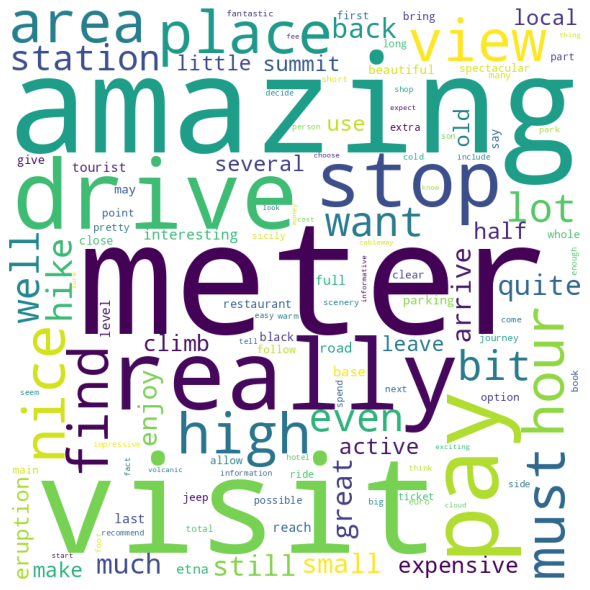

----------------------------------


Wordcloud for Review_Topic_1
0    414
1     64
Name: Review_sentiment_rating, dtype: int64


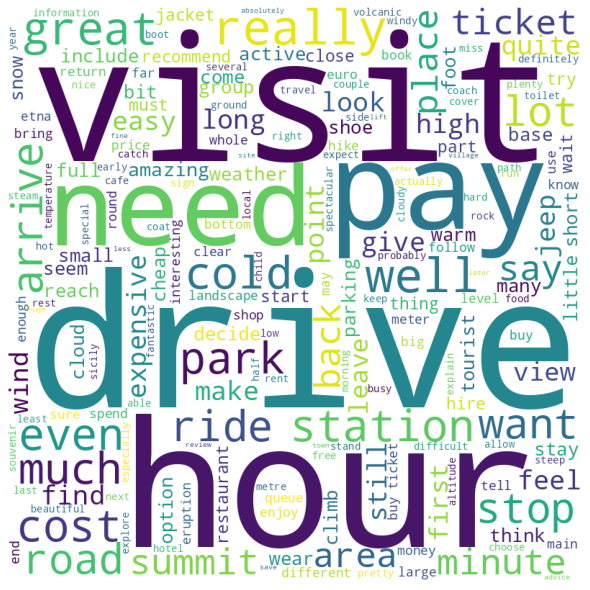

----------------------------------


Wordcloud for Review_Topic_2
0    275
1     24
Name: Review_sentiment_rating, dtype: int64


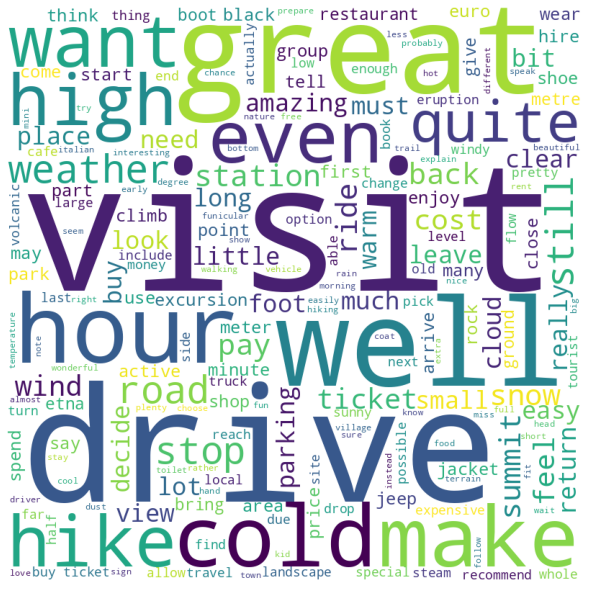

----------------------------------




In [45]:
for i in lda_review_data_tuned.filter(regex='Review_Topic_'):
    print('Wordcloud for {}'.format(i))
    review_topic = lda_review_data_tuned[lda_review_data_tuned['Review_Dominant_Topic']== i[len('Review_'):]]
    print(review_topic['Review_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_review_tuned, plot='wordcloud', topic_num=i[len('Review_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_review_tuned, plot='bigram', topic_num=i[len('Review_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_review_tuned, plot='trigram', topic_num=i[len('Review_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Reviews - SENTIMENT POSITIVE

Wordcloud for Review_Topic_0
0    138
Name: Review_sentiment_rating, dtype: int64


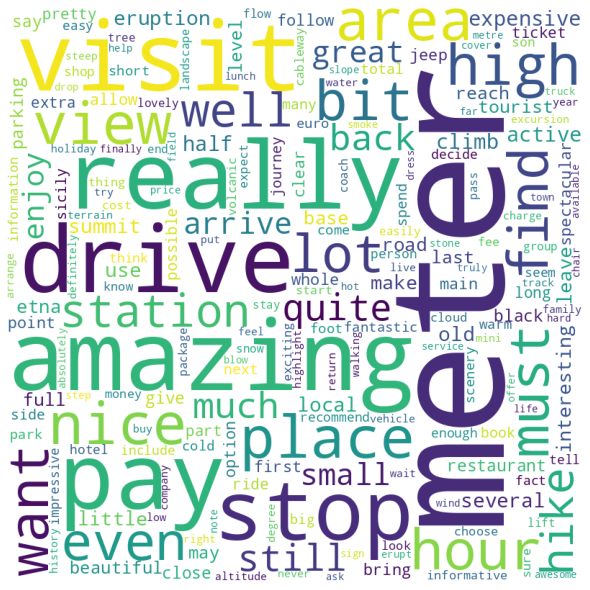

----------------------------------


Wordcloud for Review_Topic_1
0    414
Name: Review_sentiment_rating, dtype: int64


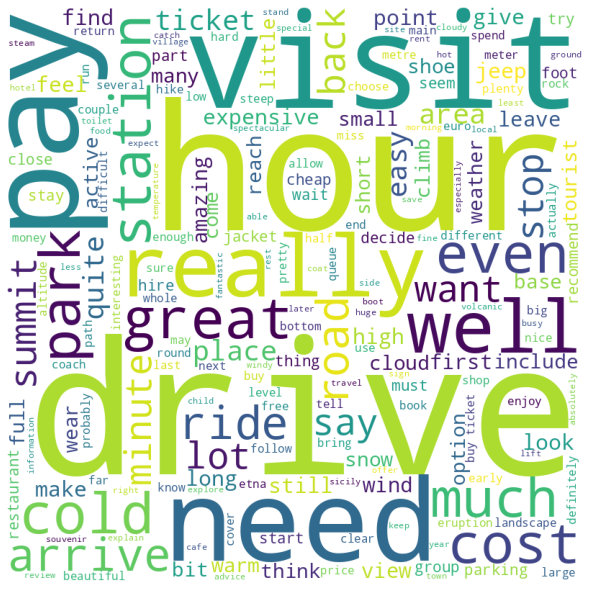

----------------------------------


Wordcloud for Review_Topic_2
0    275
Name: Review_sentiment_rating, dtype: int64


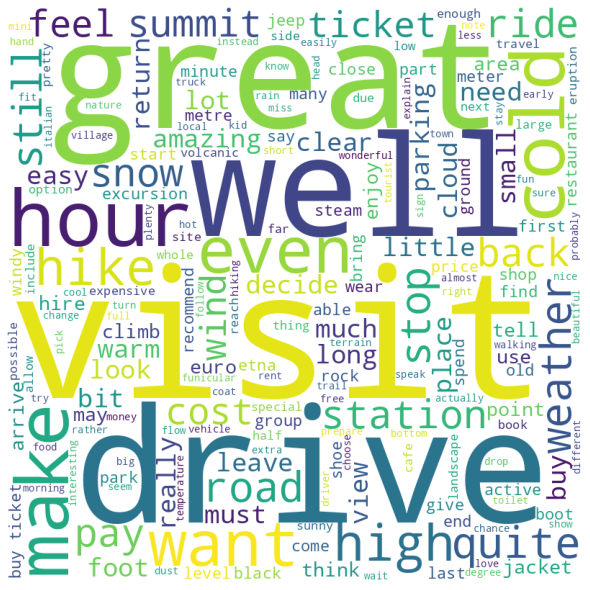

----------------------------------




In [46]:
for i in lda_review_data_tuned.filter(regex='Review_Topic_'):
    print('Wordcloud for {}'.format(i))
    review_topic = lda_review_data_tuned[lda_review_data_tuned['Review_sentiment_rating']== 0]
    review_topic = review_topic[review_topic['Review_Dominant_Topic']== i[len('Review_'):]]
    print(review_topic['Review_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_review_tuned, plot='wordcloud', topic_num=i[len('Review_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_review_tuned, plot='bigram', topic_num=i[len('Review_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_review_tuned, plot='trigram', topic_num=i[len('Review_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Reviews - SENTIMENT NEGATIVE

Wordcloud for Review_Topic_0
1    17
Name: Review_sentiment_rating, dtype: int64


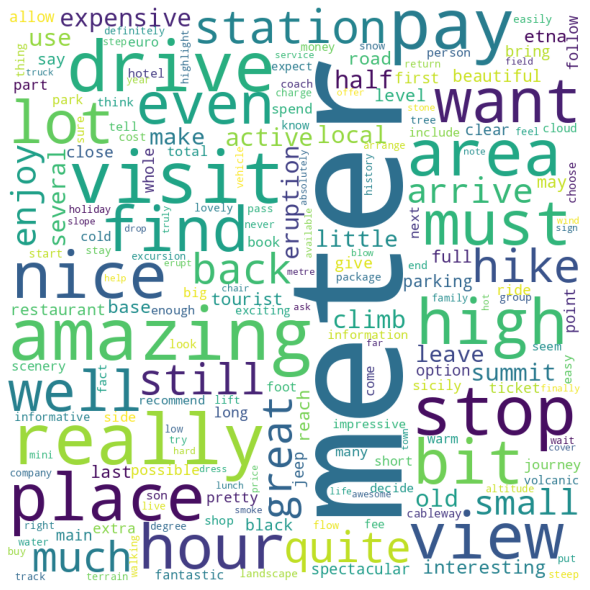

----------------------------------


Wordcloud for Review_Topic_1
1    64
Name: Review_sentiment_rating, dtype: int64


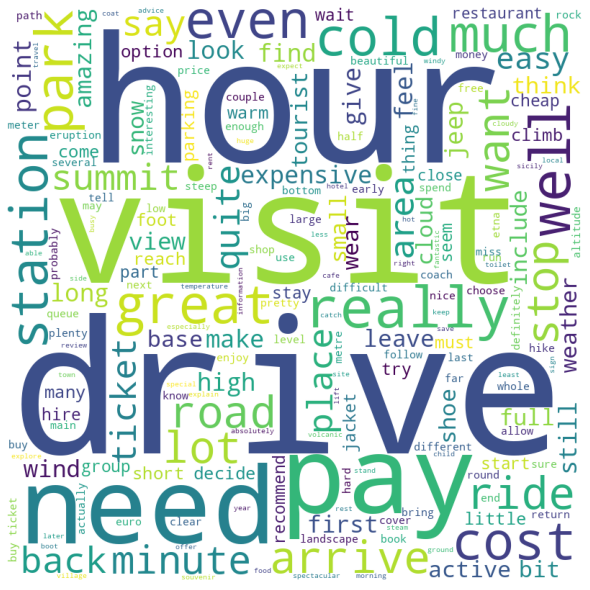

----------------------------------


Wordcloud for Review_Topic_2
1    24
Name: Review_sentiment_rating, dtype: int64


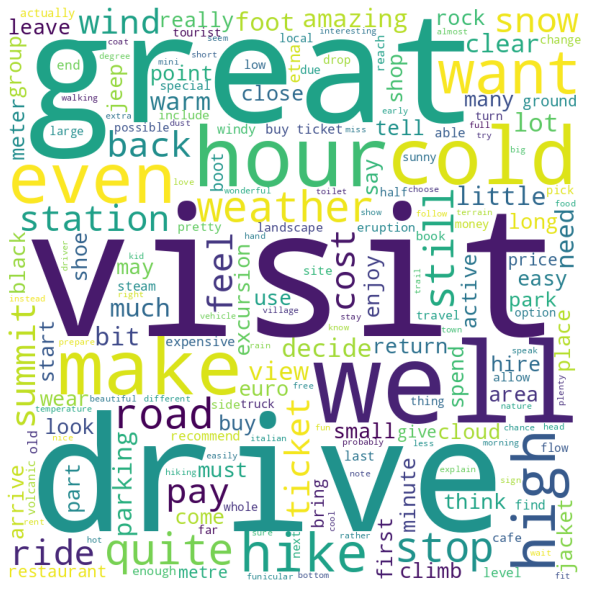

----------------------------------




In [47]:
for i in lda_review_data_tuned.filter(regex='Review_Topic_'):
    print('Wordcloud for {}'.format(i))
    review_topic = lda_review_data_tuned[lda_review_data_tuned['Review_sentiment_rating']== 1]
    review_topic = review_topic[review_topic['Review_Dominant_Topic']== i[len('Review_'):]]
    print(review_topic['Review_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_review_tuned, plot='wordcloud', topic_num=i[len('Review_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_review_tuned, plot='bigram', topic_num=i[len('Review_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_review_tuned, plot='trigram', topic_num=i[len('Review_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Evaluation of the model

In [48]:
# Evaluation of the model
evaluate_model(lda_review_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

In [49]:
lda_review_data_tuned

Review_content  \
0    extraordinary active beautiful landscape ever ...   
1    small child august use company sight however g...   
2    follow unheard deduction price ast convenient ...   
3    stay half hour parking place choose early_morn...   
4    beloved chat various thing evening mention ups...   
..                                                 ...   
927  back arrive southern yesterday etna high possi...   
928  expensive ride summit try avoid crowd tourist ...   
929  drive station nice visited relief give heat ba...   
930  unique chance climb active ride quite expensiv...   
931  group great visit place big luca entertain wel...   

     Review_sentiment_rating  Review_Topic_0  Review_Topic_1  Review_Topic_2  \
0                          0        0.009175        0.859691        0.131135   
1                          0        0.494376        0.497661        0.007963   
2                          0        0.508946        0.460836        0.030218   
3                          0        0.005486        0.660059        0.334455   
4                          0        0.000953        0.998054        0.000993   
..                       ...             ...             ...             ...   
927                        0        0.989879        0.005025        0.005096   
928                        1        0.039775        0.923802        0.036423   
929                        0        0.645966        0.329605        0.024429   
930                        0        0.026311        0.944776        0.028914   
931                        0        0.037001        0.039126        0.923873   

    Review_Dominant_Topic  Review_Perc_Dominant_Topic  
0                 Topic_1                        0.86  
1                 Topic_1                        0.50  
2                 Topic_0                        0.51  
3                 Topic_1                        0.66  
4                 Topic_1                        1.00  
..                    ...                         ...  
927               Topic_0                        0.99  
928               Topic_1                        0.92  
929               Topic_0                        0.65  
930               Topic_1                        0.94  
931               Topic_2                        0.92  

[932 rows x 7 columns]

In [50]:
lda_review_data_tuned.to_csv(base_dir + 'data/bus/lda_review_data_tuned.csv', index=False)

In [51]:
save_model(lda_review_tuned, base_dir + 'models/bus/model_review_jupyter')

Model Succesfully Saved


(<gensim.models.ldamulticore.LdaMulticore at 0x7fdf45dc8ee0>,
 '/mnt/g/My Drive/Academy/+ Papers/en_proceso/mount_etna/models/bus/model_review_jupyter.pkl')

In [52]:
lda_review_data_tuned

Review_content  \
0    extraordinary active beautiful landscape ever ...   
1    small child august use company sight however g...   
2    follow unheard deduction price ast convenient ...   
3    stay half hour parking place choose early_morn...   
4    beloved chat various thing evening mention ups...   
..                                                 ...   
927  back arrive southern yesterday etna high possi...   
928  expensive ride summit try avoid crowd tourist ...   
929  drive station nice visited relief give heat ba...   
930  unique chance climb active ride quite expensiv...   
931  group great visit place big luca entertain wel...   

     Review_sentiment_rating  Review_Topic_0  Review_Topic_1  Review_Topic_2  \
0                          0        0.009175        0.859691        0.131135   
1                          0        0.494376        0.497661        0.007963   
2                          0        0.508946        0.460836        0.030218   
3                          0        0.005486        0.660059        0.334455   
4                          0        0.000953        0.998054        0.000993   
..                       ...             ...             ...             ...   
927                        0        0.989879        0.005025        0.005096   
928                        1        0.039775        0.923802        0.036423   
929                        0        0.645966        0.329605        0.024429   
930                        0        0.026311        0.944776        0.028914   
931                        0        0.037001        0.039126        0.923873   

    Review_Dominant_Topic  Review_Perc_Dominant_Topic  
0                 Topic_1                        0.86  
1                 Topic_1                        0.50  
2                 Topic_0                        0.51  
3                 Topic_1                        0.66  
4                 Topic_1                        1.00  
..                    ...                         ...  
927               Topic_0                        0.99  
928               Topic_1                        0.92  
929               Topic_0                        0.65  
930               Topic_1                        0.94  
931               Topic_2                        0.92  

[932 rows x 7 columns]